In [1]:
# import all the modules

import os
import csv
import requests
from zipfile import ZipFile
from io import BytesIO, TextIOWrapper
from urllib.request import urlopen
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import geopandas as gpd
import pgeocode
import seaborn as sns
from geopy.geocoders import Nominatim 
import time
import folium
from folium import Choropleth, CircleMarker, LayerControl, GeoJsonTooltip
from folium.plugins import HeatMap, TimeSliderChoropleth
import numpy as np


Grab zip files from MHSA: https://arlweb.msha.gov/OpenGovernmentData/OGIMSHA.asp

In [2]:
# grab zip file MHSA dataset
response = requests.get('https://arlweb.msha.gov/OpenGovernmentData/DataSets/Accidents.zip')

# extract zipfile
with ZipFile(BytesIO(response.content)) as zf:
    # get our text file
    filename = zf.namelist() 

    # open text file
    with zf.open(filename[0]) as file:
        # make it a dataframe
        accidents = pd.read_csv(file, on_bad_lines='skip', 
                                encoding='ISO-8859-1', delimiter='|')


accidents.head()

C:\Users\Jessie\AppData\Local\Temp\ipykernel_28284\1900781676.py:12: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv(file, on_bad_lines='skip',


,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,...,DAYS_RESTRICT,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND
0,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",MPH,220132310045,3,"STRIP, QUARY, OPEN PIT",08/12/2013,...,2.0,0,N,08/19/2013,?,NO VALUE FOUND,NaN,Employee says he slipped off back of fuel truc...,NaN,M
1,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",NaN,220241210019,30,MILL OPERATION/PREPARATION PLANT,04/22/2024,...,0.0,0,N,04/22/2024,?,NO VALUE FOUND,NaN,While blowing lime dust from the lime cooler a...,NaN,M
2,100009,M00024,Legacy Vulcan Corp (Form:Vulcan Materials Co),L16168,"Vulcan Construction Materials, LLC",NaN,220053250019,3,"STRIP, QUARY, OPEN PIT",11/13/2005,...,13.0,0,N,12/01/2005,?,NO VALUE FOUND,NaN,2 employees were attempting to load troughing ...,320053360009,M
3,100011,M11763,Imerys S A,L17074,Imerys Pigments LLC,NaN,220062000052,30,MILL OPERATION/PREPARATION PLANT,07/14/2006,...,0.0,0,N,07/15/2006,?,NO VALUE FOUND,NaN,Employee was pushing against pry bar. Bar slip...,NaN,M
4,100011,M11763,Imerys S A,0090005,Imerys Carbonates LLC,NaN,220090120006,30,MILL OPERATION/PREPARATION PLANT,01/08/2009,...,0.0,0,N,01/09/2009,?,NO VALUE FOUND,NaN,Employee tripped on c-channel at #6 silo. Fel...,NaN,M


Grab zip files for addresses.

In [5]:
# grab zip file for addresses
response = requests.get('https://arlweb.msha.gov/OpenGovernmentData/DataSets/AddressofRecord.zip')

# extract zipfile
with ZipFile(BytesIO(response.content)) as zf:
    # get our text file
    filename = zf.namelist()

    # open text file
    with zf.open(filename[0]) as file:
        # make it a dataframe
        address = pd.read_csv(file, on_bad_lines='skip', 
                              encoding='ISO-8859-1', delimiter='|',
                              dtype={'ZIP_CD': str})
        
address.head()

,MINE_ID,MINE_NAME,CONTACT_TITLE,NEAREST_TOWN,BUSINESS_NAME,STREET,PO_BOX,CITY,STATE_ABBR,FIPS_STATE_CD,STATE,ZIP_CD,COUNTRY,PROVINCE,POSTAL_CD,MINE_TYPE_CD,MINE_STATUS,MINE_STATUS_DT,PRIMARY_SIC_CD,COAL_METAL_IND
0,100003,O'Neal Quarry & Mill,Operations Manager,Calera,"Lhoist North America of Alabama, LLC",2885 Hwy 31 South,NaN,Calera,AL,1.0,Alabama,35040,USA,NaN,NaN,Surface,Active,01/22/1979,Lime,M
1,100004,Brierfield Quarry,Quarry Manager,Brierfield,"Lhoist North America of Alabama, LLC",14786 Montevallo Road,NaN,Brierfield,AL,1.0,Alabama,35035,USA,NaN,NaN,Surface,Active,03/04/2003,"Crushed, Broken Limestone NEC",M
2,100005,Birmingham Plant,NaN,NaN,Allied Lime Company,NaN,36130,BIRMINGHAM,AL,1.0,Alabama,35236,USA,NaN,NaN,Surface,Abandoned,08/15/1989,"Crushed, Broken Limestone NEC",M
3,100006,Auburn Quarry,Safety Representative,Auburn,"Martin Marietta Materials, Inc.",245 Rockwood Rd,NaN,Tyrone,GA,13.0,Georgia,30290,USA,NaN,NaN,Surface,Active,09/24/1976,"Crushed, Broken Limestone NEC",M
4,100008,Landmark Plant,Operations Manager,Alabaster,Cheney Lime & Cement Company,1152 Old Hwy 31,NaN,Alabaster,AL,1.0,Alabama,35007,USA,NaN,NaN,Surface,Active,11/14/1975,Lime,M


For address, zip code was used to plot the data on the map due to limited traffic for Nominatim API. This is due to the address dataframe having over 90000 rows to loop through, which would have taken approximately 53 hours alone to ensure it did not overload the API. 

In [6]:
# from zip code -> get lon and lat
# set it to us
nomi = pgeocode.Nominatim('us')

# drop rows where zip codes are missing
address = address.dropna(subset=['ZIP_CD'])

# get zip code column into a list
zipcode = address['ZIP_CD'].astype(str).tolist()

# get lat and lon for all zip codes
locations = nomi.query_postal_code(zipcode)

# put it in the address column
address['lat'] = locations['latitude'].values
address['lon'] = locations['longitude'].values

If it wasn't for the API traffic limit, the following code would have been run. 

From the street address, I've noticed that many of Alabama addresses are either showing random spots in the map (parking lot, shopping centre, etc.) or not found. This was due to some districts inside of the city was recorded instead of city name, just like how North York is part of Toronto, but Nominatim couldn't identify it. Some data also started with a PO Box, which wasn't a standard format. This is why just generalized city_state location data is also included if the full address fails.

In [ ]:
# initialize Nominatim 
geolocator = Nominatim(user_agent="addressGeocoder")

# function for getting coordinates
def locate_coordinate(row):
    # get street address from the dataframe 
    full_address = f"{row['STREET']}, {row['CITY']}, {row['STATE_ABBR']}"
    # also get city and state
    city_state = f"{row['CITY']}, {row['STATE_ABBR']}"
    
    try:
        # attempt to get a location for full address
        location = geolocator.geocode(full_address)
        time.sleep(1)  # delay
        
        # extract lat and lon
        if location:
            return location.latitude, location.longitude
        
        # if failed, use city and state 
        location = geolocator.geocode(city_state)
        time.sleep(1) # delay
        
        # extract lat and lon
        if location:
            return location.latitude, location.longitude
        
        # if both fails, return none.
        return None, None
    
    # if there's an error, print out
    except Exception as e:
        print(f"Error geocoding {full_address}: {e}")
        return None, None

# add a progress tracker to find how much has been processed
def geocode_with_progress(df):
    total = len(df)
    results = []
    for i, row in df.iterrows():
        lat, lon = locate_coordinate(row)
        results.append((lat, lon))
        # print progress bc I want to track how long I need to wait
        if (i + 1) % 10 == 0 or i + 1 == total:  # updated every 10 rows and print out
            print(f"Progress: {i + 1}/{total} rows processed")
    return results

# add lat and lon to the dataframe 
address[['lat', 'lon']] = pd.DataFrame(geocode_with_progress(address), columns=['lat', 'lon'])

Match address and accident dataframe with mine ids:

In [7]:
# merge dataframes 
accidents = accidents.merge(address[['MINE_ID', 'lat', 'lon', 'CITY', 'STATE_ABBR']],
                            on = 'MINE_ID', how='left')

accidents.head()

,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,...,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND,lat,lon,CITY,STATE_ABBR
0,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",MPH,220132310045,3,"STRIP, QUARY, OPEN PIT",08/12/2013,...,?,NO VALUE FOUND,NaN,Employee says he slipped off back of fuel truc...,NaN,M,33.1098,-86.7560,Calera,AL
1,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",NaN,220241210019,30,MILL OPERATION/PREPARATION PLANT,04/22/2024,...,?,NO VALUE FOUND,NaN,While blowing lime dust from the lime cooler a...,NaN,M,33.1098,-86.7560,Calera,AL
2,100009,M00024,Legacy Vulcan Corp (Form:Vulcan Materials Co),L16168,"Vulcan Construction Materials, LLC",NaN,220053250019,3,"STRIP, QUARY, OPEN PIT",11/13/2005,...,?,NO VALUE FOUND,NaN,2 employees were attempting to load troughing ...,320053360009,M,33.3813,-86.7046,BIRMINGHAM,AL
3,100011,M11763,Imerys S A,L17074,Imerys Pigments LLC,NaN,220062000052,30,MILL OPERATION/PREPARATION PLANT,07/14/2006,...,?,NO VALUE FOUND,NaN,Employee was pushing against pry bar. Bar slip...,NaN,M,33.1756,-86.3574,Sylacauga,AL
4,100011,M11763,Imerys S A,0090005,Imerys Carbonates LLC,NaN,220090120006,30,MILL OPERATION/PREPARATION PLANT,01/08/2009,...,?,NO VALUE FOUND,NaN,Employee tripped on c-channel at #6 silo. Fel...,NaN,M,33.1756,-86.3574,Sylacauga,AL


Make the dataframe a geodataframe:

In [8]:
accidents_gdf = gpd.GeoDataFrame(accidents,
                                 geometry=gpd.points_from_xy(accidents['lon'],
                                                             accidents['lat']),
                                                             crs="EPSG:4326")

# remove empty geometries and only keep not-empty ones
accidents_gdf = accidents_gdf[~accidents_gdf.geometry.is_empty]

Make a US map of accidents using the data above.

In [9]:
# fetch GeoJSON data for state boundaries from open source
geojson_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
response = requests.get(geojson_url)
state_geo = response.json()

# ensure we are getting a right type of info added
print(state_geo['features'][0]['id'])

AL


In [10]:
# centre the map
us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# calclate density of accidents per state 
state_accident_density = (
    accidents.groupby('STATE_ABBR')
    .size()
    .reset_index(name="Accident_Count")
    .set_index('STATE_ABBR')
    .to_dict()['Accident_Count']
)

# density converted to GeoJSon feature
for feature in state_geo['features']:
    state_abbr = feature['id']
    feature['properties']['Accident_Count'] = state_accident_density.get(state_abbr, 0)

# add state boundaries 
choropleth = Choropleth(
    geo_data=state_geo,
    data=state_accident_density,
    key_on="feature.id",  
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Accidents by State",
    nan_fill_color="gray",
).add_to(us_map)

# add tool tip for state name and accident count
tooltip = GeoJsonTooltip(
    fields=['name', 'Accident_Count'],  
    aliases=["State:", "Accidents:"], 
    localize=True,
    sticky=True,
    labels=True,
    style="background-color: white; color: black; font-weight: bold;",
)
choropleth.geojson.add_child(tooltip)

# add heat map to show density concentration throughout the states
heat_data = accidents[['lat', 'lon']].dropna().values.tolist()
HeatMap(heat_data, radius=15, blur=10).add_to(us_map)

# add layer ctrl
LayerControl().add_to(us_map)

# save to html
us_map.save("us_accident_density_map.html")
print("Map saved as 'us_accident_density_map.html'")

Map saved as 'us_accident_density_map.html'


Let's look at the columns and see if there are any visualizations we can develop..  

In [11]:
accidents.columns

Index(['MINE_ID', 'CONTROLLER_ID', 'CONTROLLER_NAME', 'OPERATOR_ID',
       'OPERATOR_NAME', 'CONTRACTOR_ID', 'DOCUMENT_NO', 'SUBUNIT_CD',
       'SUBUNIT', 'ACCIDENT_DT', 'CAL_YR', 'CAL_QTR', 'FISCAL_YR',
       'FISCAL_QTR', 'ACCIDENT_TIME', 'DEGREE_INJURY_CD', 'DEGREE_INJURY',
       'FIPS_STATE_CD', 'UG_LOCATION_CD', 'UG_LOCATION', 'UG_MINING_METHOD_CD',
       'UG_MINING_METHOD', 'MINING_EQUIP_CD', 'MINING_EQUIP', 'EQUIP_MFR_CD',
       'EQUIP_MFR_NAME', 'EQUIP_MODEL_NO', 'SHIFT_BEGIN_TIME',
       'CLASSIFICATION_CD', 'CLASSIFICATION', 'ACCIDENT_TYPE_CD',
       'ACCIDENT_TYPE', 'NO_INJURIES', 'TOT_EXPER', 'MINE_EXPER', 'JOB_EXPER',
       'OCCUPATION_CD', 'OCCUPATION', 'ACTIVITY_CD', 'ACTIVITY',
       'INJURY_SOURCE_CD', 'INJURY_SOURCE', 'NATURE_INJURY_CD',
       'NATURE_INJURY', 'INJ_BODY_PART_CD', 'INJ_BODY_PART', 'SCHEDULE_CHARGE',
       'DAYS_RESTRICT', 'DAYS_LOST', 'TRANS_TERM', 'RETURN_TO_WORK_DT',
       'IMMED_NOTIFY_CD', 'IMMED_NOTIFY', 'INVEST_BEGIN_DT', 'NARRATIVE'

Let's create a simple graph to observe the trends in accidents over time.

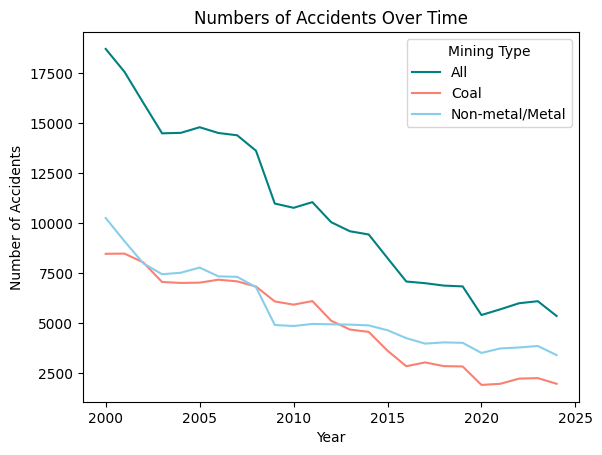

In [12]:
# ensure datetime is in datetime format
accidents['ACCIDENT_DT'] = pd.to_datetime(accidents['ACCIDENT_DT'])
# get years
accidents['YEAR'] = accidents['ACCIDENT_DT'].dt.year

# group by years
accidents_yearly = accidents.groupby(['YEAR']).size().reset_index(name='COUNT')

# separate by non-metal/metal and coal
coal = accidents[accidents['COAL_METAL_IND'] == 'C']
coal_year = coal.groupby(['YEAR']).size().reset_index(name='COUNT')

non_metal = accidents[accidents['COAL_METAL_IND'] == 'M']
non_metal_year = non_metal.groupby(['YEAR']).size().reset_index(name='COUNT')

# plot for all, coal, nm/m
sns.lineplot(data=accidents_yearly, x='YEAR', y='COUNT', 
             color='teal', label='All')
sns.lineplot(data=coal_year, x='YEAR', y='COUNT', 
             color='salmon', label='Coal')
sns.lineplot(data=non_metal_year, x='YEAR', y='COUNT', 
             color='skyblue', label='Non-metal/Metal')

plt.title('Numbers of Accidents Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='Mining Type')
plt.show()

The dataset contains data from 2000 up until now, updating every Fridays. The graph shows a clear decline in number of accidents over time. 

Now looking at the severity of the accidents, how many days were lost, etc:

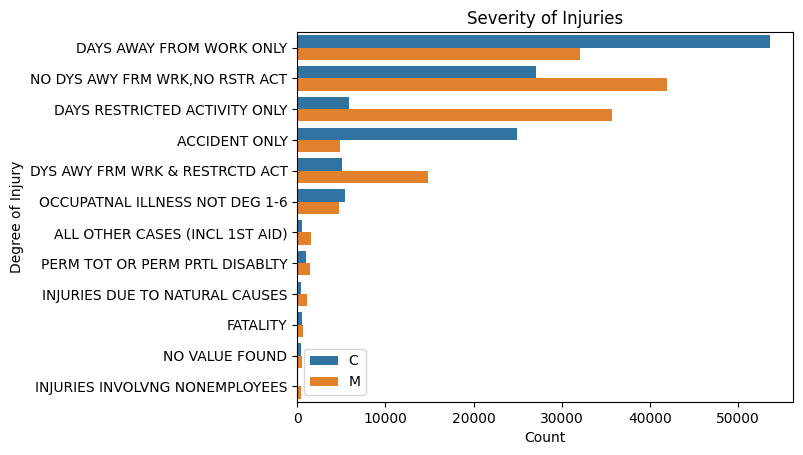

In [13]:
# groupby type of the mine
severity = accidents.groupby(['COAL_METAL_IND', 
                              'DEGREE_INJURY']).size().reset_index(name='count').sort_values(by='count', ascending=False)

# plot for severity 
sns.barplot(data=severity,
              y='DEGREE_INJURY',
              x='count', hue='COAL_METAL_IND')

plt.title('Severity of Injuries')
plt.xlabel('Count')
plt.ylabel('Degree of Injury')
plt.legend()
plt.show()

Top 3:
* Workers off for a few days from work.
* No days away from work, no restricted activities.
* Days with restricted activity only.

Let's look at yearly trends for those three:

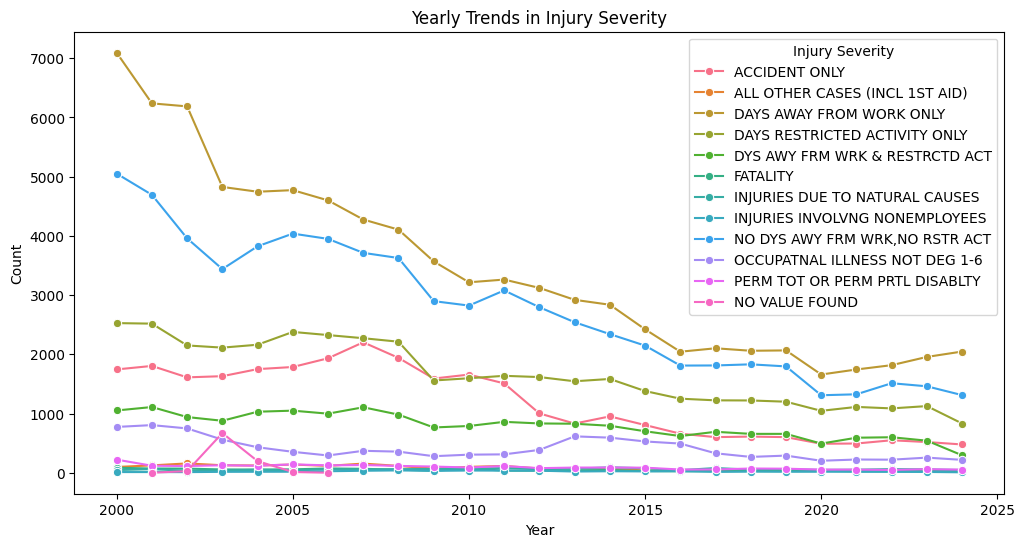

In [14]:
plt.figure(figsize=(12, 6))
# extract year
accidents['Year'] = pd.to_datetime(accidents['ACCIDENT_DT']).dt.year

# group by year and the degree of injury then count 
yearly_data = accidents.groupby(['Year', 'DEGREE_INJURY']).size().reset_index(name='count')

# sort
yearly_data = yearly_data.sort_values(by=['Year', 'DEGREE_INJURY'])

# plot
sns.lineplot(data=yearly_data, x='Year', y='count', hue='DEGREE_INJURY', marker='o')
plt.title('Yearly Trends in Injury Severity')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Injury Severity')
plt.show()

Mostly downward trend and maybe the slight increase after 2020 with 'DAYS AWAY FROM WORK ONLY' could be due to work force returning. 

Was there any accidents by equipment?

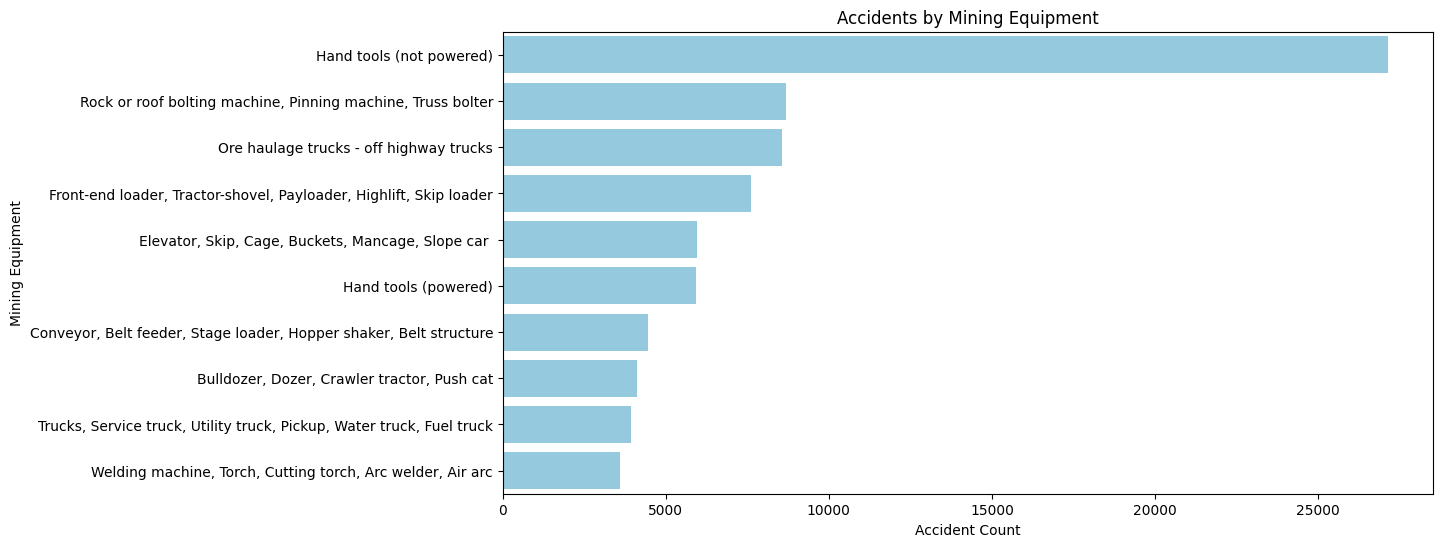

In [15]:
# count equipment except for no value found
equipment_counts = accidents[accidents['MINING_EQUIP'] != 'NO VALUE FOUND']['MINING_EQUIP'].value_counts().head(10)

# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=equipment_counts.values, 
            y=equipment_counts.index,
            color='skyblue')
plt.title('Accidents by Mining Equipment')
plt.xlabel('Accident Count')
plt.ylabel('Mining Equipment')
plt.show()

Now look at the yearly trend:

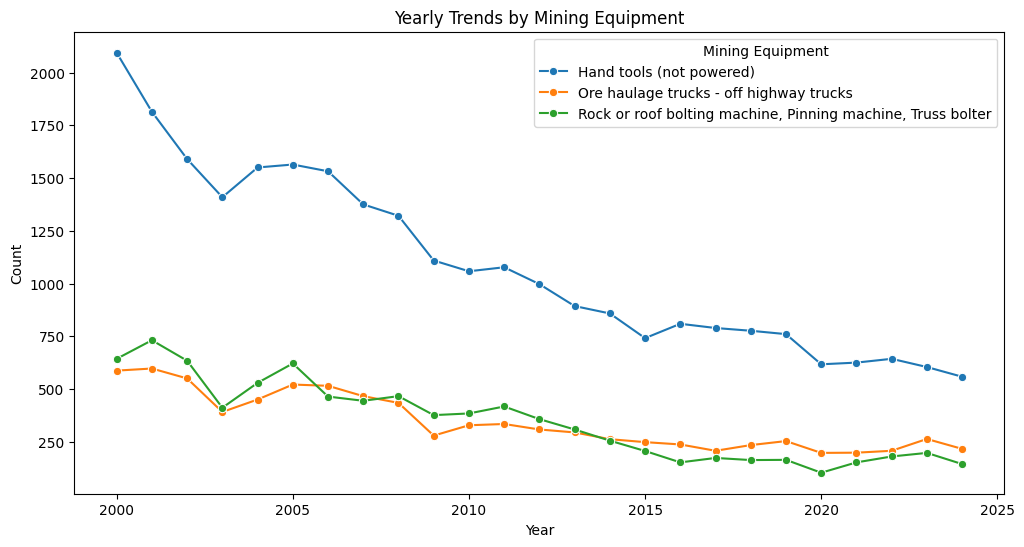

In [16]:
# filter equipment for only top three
equipment = ['Hand tools (not powered)', 
             'Rock or roof bolting machine, Pinning machine, Truss bolter',
             'Ore haulage trucks - off highway trucks']

filtered_data = accidents[accidents['MINING_EQUIP'].isin(equipment)]

# group by year followed by equipment then count
yearly_data = filtered_data.groupby(['YEAR', 'MINING_EQUIP']).size().reset_index(name='count')

# sort
yearly_data = yearly_data.sort_values(by=['YEAR', 'MINING_EQUIP'])

# plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_data, x='YEAR', y='count', hue='MINING_EQUIP', marker='o')
plt.title('Yearly Trends by Mining Equipment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Mining Equipment')
plt.show()

The trend is generally declining for the top 3 part. 

How about looking into the number of experience for handtools? 

C:\Users\Jessie\AppData\Local\Temp\ipykernel_28284\3085539684.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ACCIDENT_DT'] = pd.to_datetime(filtered_data['ACCIDENT_DT'])
C:\Users\Jessie\AppData\Local\Temp\ipykernel_28284\3085539684.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['ACCIDENT_DT'].dt.year
C:\Users\Jessie\AppData\Local\Temp\ipykernel_28284\3085539684.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

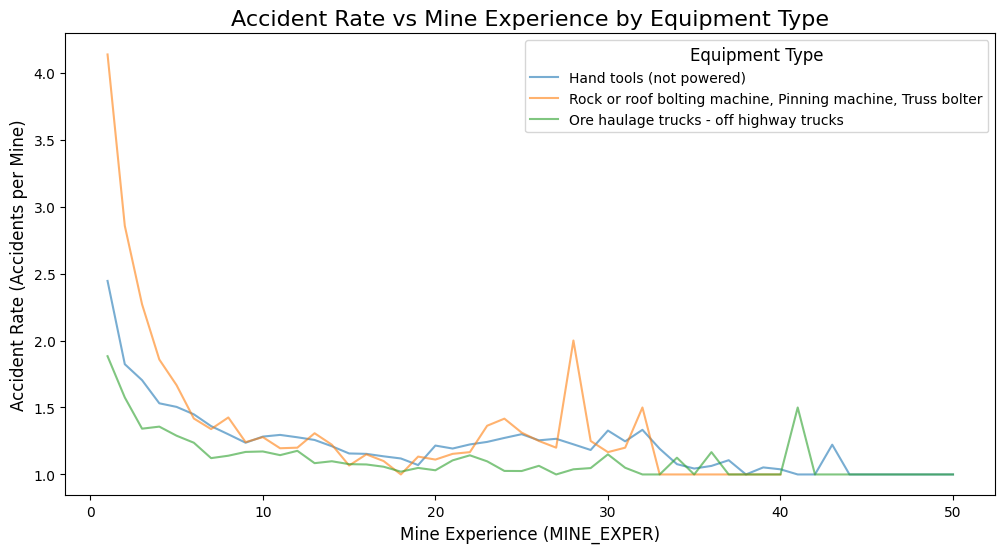

In [17]:
# filter for equips
equipment = ['Hand tools (not powered)',
             'Rock or roof bolting machine, Pinning machine, Truss bolter',
             'Ore haulage trucks - off highway trucks']

filtered_data = accidents[accidents['MINING_EQUIP'].isin(equipment)]

# convert to datetime and calculate the year
filtered_data['ACCIDENT_DT'] = pd.to_datetime(filtered_data['ACCIDENT_DT'])
filtered_data['year'] = filtered_data['ACCIDENT_DT'].dt.year

# round up to the nearest digit for experience bc some of them are not integer
filtered_data['MINE_EXPER'] = np.ceil(filtered_data['MINE_EXPER'])

# group by mine experience and calculate accident rate (number of accidents per mine)
accident_rate_by_experience = (
    filtered_data.groupby(['MINE_EXPER', 'MINING_EQUIP'])
    .agg(
        accident_count=('ACCIDENT_DT', 'count'),
        mine_count=('MINE_ID', 'nunique')
    )
    .reset_index()
)

# calc accident rate as accidents per mine experience
accident_rate_by_experience['accident_rate'] = (
    accident_rate_by_experience['accident_count'] / accident_rate_by_experience['mine_count']
)

# plot
plt.figure(figsize=(12, 6))

for equipment_type in equipment:
    subset = accident_rate_by_experience[accident_rate_by_experience['MINING_EQUIP'] == equipment_type]
    plt.plot(
        subset['MINE_EXPER'], 
        subset['accident_rate'], 
        label=equipment_type, 
        alpha=0.6
    )

plt.title('Accident Rate vs Mine Experience by Equipment Type', fontsize=16)
plt.xlabel('Mine Experience (MINE_EXPER)', fontsize=12)
plt.ylabel('Accident Rate (Accidents per Mine)', fontsize=12)
plt.legend(title="Equipment Type", fontsize=10, title_fontsize=12)
plt.show()

Looking at the severity of accident per mining equipment involved for top three.

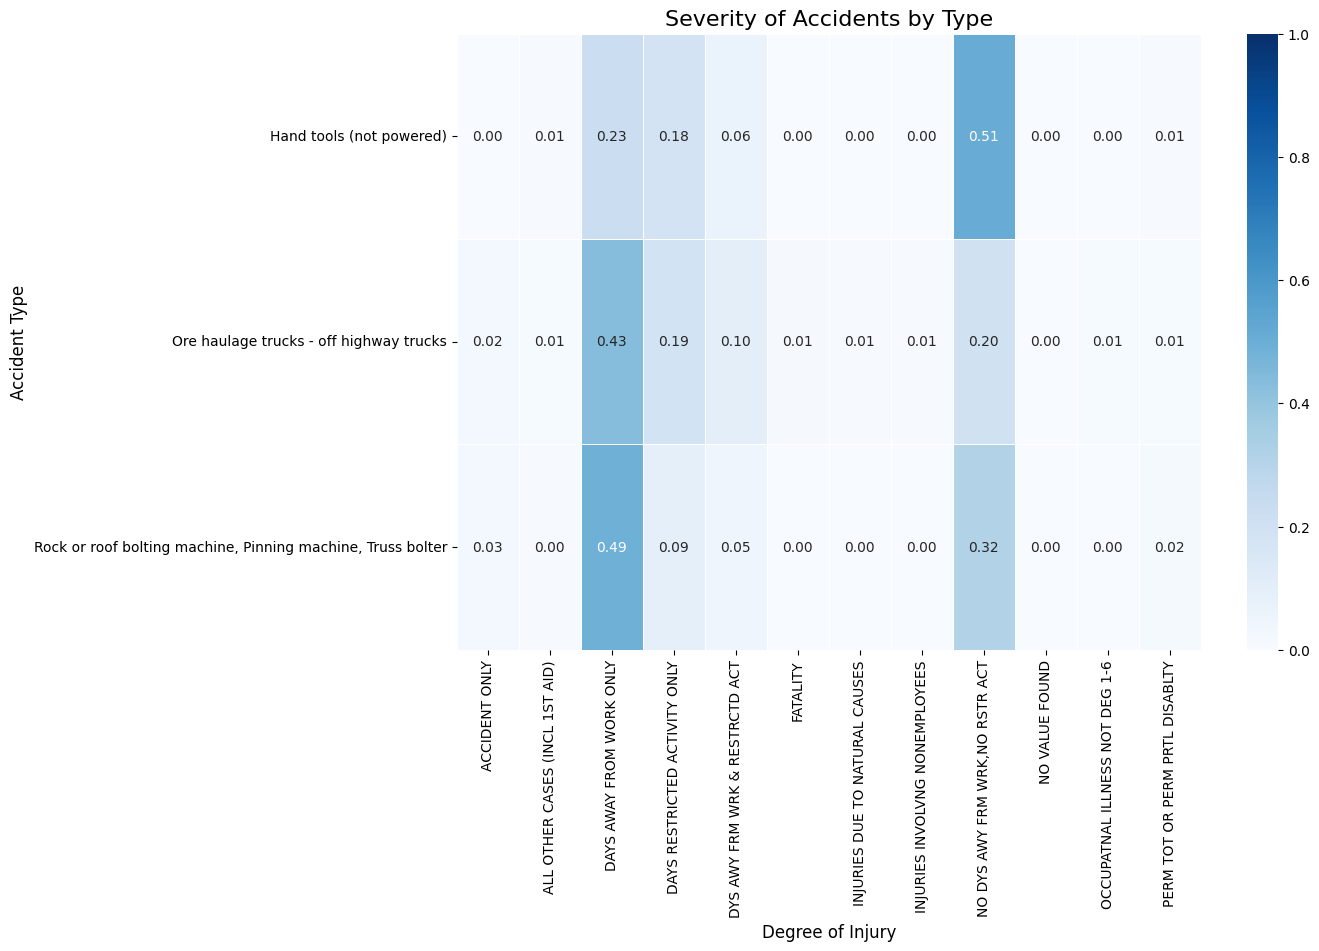

In [23]:
# selected equipment only top 3 shown
equipment = ['Hand tools (not powered)',
             'Rock or roof bolting machine, Pinning machine, Truss bolter',
             'Ore haulage trucks - off highway trucks']

# filter to only include these 3
filtered_data = accidents[accidents['MINING_EQUIP'].isin(equipment)]

# groupby the equipment type involved and degree of injury
severity_by_accident_type = (
    filtered_data.groupby(['MINING_EQUIP', 'DEGREE_INJURY'])
    .size()
    .reset_index(name='Count')
    .pivot(index='MINING_EQUIP', columns='DEGREE_INJURY', values='Count')
    .fillna(0)
)

# normalized by accident type
normalized = severity_by_accident_type.div(severity_by_accident_type.sum(axis=1), axis=0)

# nomralized heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    normalized, 
    annot=True,
    fmt=".2f", # capping at 2 decimals 
    cmap="Blues", 
    cbar=True, 
    linewidths=0.5,
    vmin=0, # ensure 0%
    vmax=1 # ensure 100%
)

plt.title('Severity of Accidents by Type', fontsize=16)
plt.xlabel('Degree of Injury', fontsize=12)
plt.ylabel('Accident Type', fontsize=12)
plt.show()

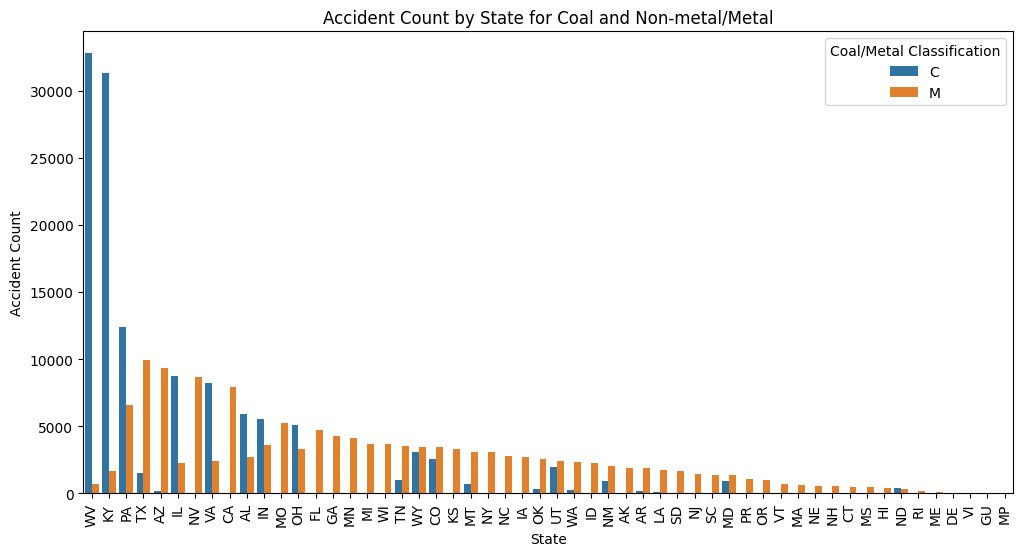

In [19]:
# groupby to count accidents by state and coal/non-metal classification
accidents_by_state = accidents.groupby(['STATE_ABBR', 'COAL_METAL_IND']).size().reset_index(name='count')

# sort
accidents_by_state = accidents_by_state.sort_values(by='count', ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(data=accidents_by_state, x='STATE_ABBR', y='count', hue='COAL_METAL_IND')
plt.title('Accident Count by State for Coal and Non-metal/Metal')
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.xticks(rotation=90)
plt.legend(title='Coal/Metal Classification')
plt.show()

So we know the top 3 mining states
Coal
* West Virginia
* Kentucky
* Pennsylvania

Non-metal/Metal
* Texas
* Arizona
* Nevada

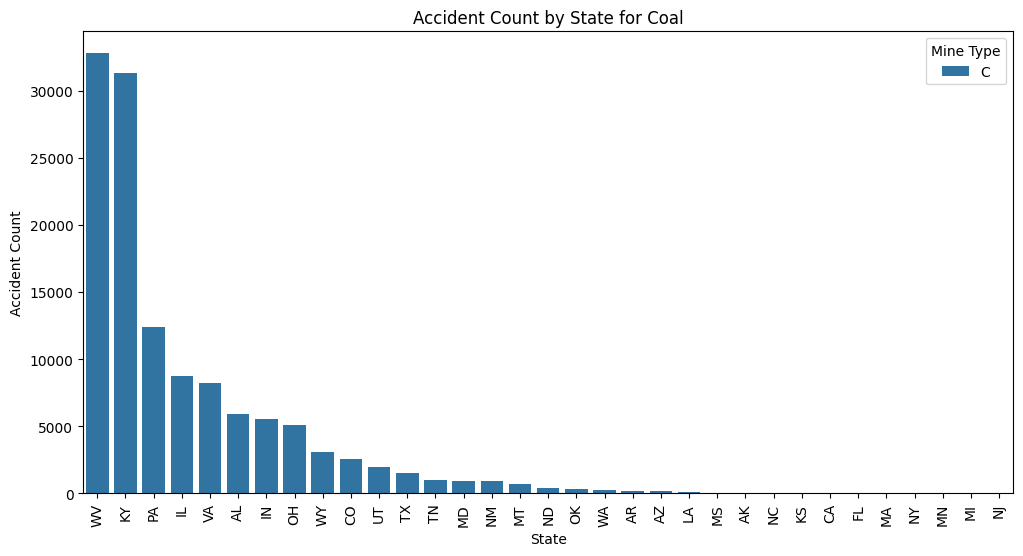

In [20]:
# filter by coal
coal_data = accidents_by_state[accidents_by_state['COAL_METAL_IND'] == 'C']

# sort
coal_data = coal_data.sort_values(by='count', ascending=False)

# Plotting the results for "Coal" classification only
plt.figure(figsize=(12, 6))
sns.barplot(data=coal_data, x='STATE_ABBR', y='count', hue='COAL_METAL_IND')
plt.title('Accident Count by State for Coal')
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.xticks(rotation=90)
plt.legend(title='Mine Type')
plt.show()

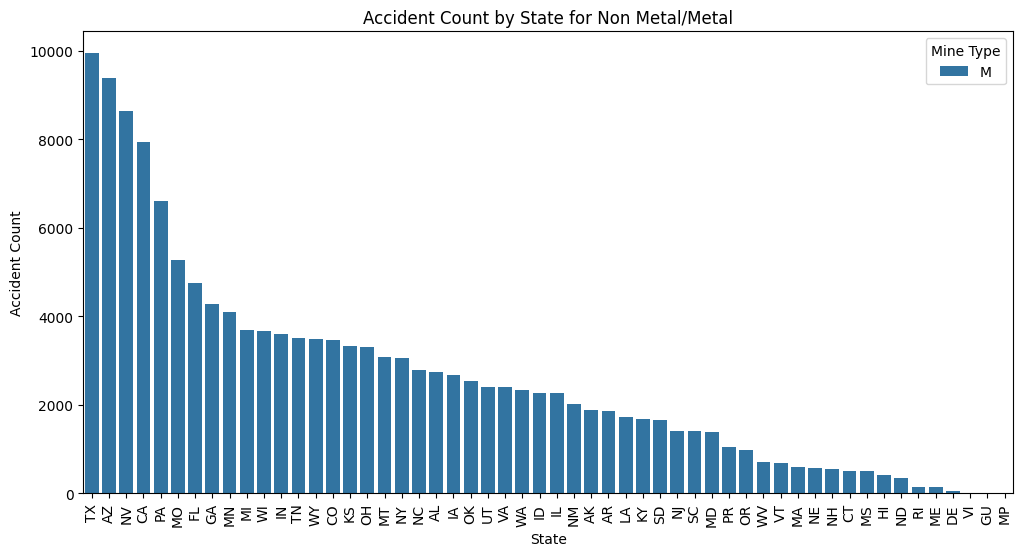

In [21]:
#filter by nonmetal-metal
metal = accidents_by_state[accidents_by_state['COAL_METAL_IND'] == 'M']

# sort
metal = metal.sort_values(by='count', ascending=False)

# Plotting the results for "Coal" classification only
plt.figure(figsize=(12, 6))
sns.barplot(data=metal, x='STATE_ABBR', y='count', hue='COAL_METAL_IND')
plt.title('Accident Count by State for Non Metal/Metal')
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.legend(title='Mine Type')
plt.xticks(rotation=90)
plt.show()

Text analysis of accident narratives

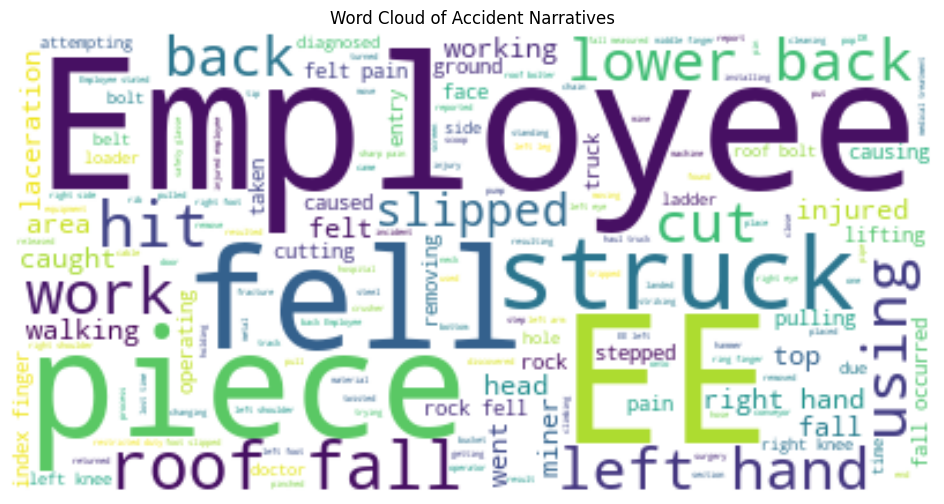

In [22]:
from wordcloud import WordCloud

# WordCloud for accident narratives
text = ' '.join(str(narrative) for narrative in accidents['NARRATIVE'].dropna())
wordcloud = WordCloud(background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Accident Narratives')
plt.show()

Most common words include "struck", "fell", "slipped", etc, relating to ergonomics.